# Linear model for the minimum-variance control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Definition
For the linear models of the eye and arm, we consider a single-input single-output discrete-time system under control with the following state-update equation:
$$
\tilde{x}_{t+1} = A\tilde{x}_t+B\left (u_t+w_t \right)
$$  
where $\tilde{x}_t$ is the $n$-dimentional state at time $t$, $u_t$ the neural driving signal at time $t$, $w_t$ is a white noise with mean zero and variance $ku_t^2$, $A$ is a fixed $n \times n$ matrix and B is a $n \times 1$ vector both describing the dynamics of the system.

In [2]:
beta = 3.9
m = 4.
A = np.array([[1., 1.],[0., 1-beta/m]])
B = np.array([0., 1/m])
k = 0.007
#k = 0.1

In [3]:
downscale = 1
downscale = 10
T = 100//downscale # target position time (steps)
R = 50//downscale # post-movement period (steps)
x0 = np.array([5., 0.]) # start from 0° with no speed
xT = np.array([20., 0.]) # reach 20° with no speed
u = np.random.uniform(-5, 5, T+R)

time = np.linspace(0, 1, T+R) # in s


## Mean and covariance matrix
$\tilde{x}_t = A\tilde{x}_{t-1}+B\left (u_{t-1}+w_{t-1} \right) \\
\tilde{x}_t = A \left (A\tilde{x}_{t-2}+B\left (u_{t-2}+w_{t-2} \right)\right) + B\left (u_{t-1}+w_{t-1} \right) \\
...\\
\tilde{x}_t = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}B \left (u_i+w_i \right)}
$
  
We deduce the mean:
$E\left [\tilde{x}_t \right] = A^t \tilde{x}_0 + \sum \limits_{i=0}^{t-1}{A^{t-1-i}Bu_i}$ since $E\left [w_t \right] = 0$.

In [4]:
def power(A, n): 
    """
    renvoie A puissance n où A est une matrice carrée
    
    See also: numpy.linalg.matrix_power
    
    """
    if n==0:
        return(np.eye(int(np.sqrt(np.size(A)))));
    else:
        return(A.dot(power(A, n-1)));

In [5]:
%%timeit
power(A, 10)

The slowest run took 36.25 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18 µs per loop


In [6]:
%%timeit
np.linalg.matrix_power(A, 10)

The slowest run took 5.24 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 14.1 µs per loop


In [7]:
def expectation(A, B, x0, u, t):
    if t == 0:
        return x0
    else:
        somme =  power(A,t).dot(x0)
        for i in np.arange(t):
            mat = power(A, t-i-1).dot(B)
            #mat = power(A, t-i-1) @ B
            somme += mat*u[i]
        return somme

In [8]:
%%timeit
expectation(A, B, x0, u, t=10)

1000 loops, best of 3: 211 µs per loop


  
Then, $cov\left [\tilde{x}_t\right ] = \sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T E\left [w_t^2 \right]} = k\sum \limits_{i=0}^{t-1}{\left (A^{t-1-i}B \right )\left (A^{t-1-i}B \right )^T u_t^2}$

In [9]:
def variance(A, B, k, u, t):
    somme = 0.
    for i in np.arange(t):
        ci0 = (power(A, t-i-1).dot(B))[0]
        somme += k*(ci0**2)*(u[i]**2)
    return somme


TODO : illustrating this computation on the bang-bang

## Minimum-variance problem

Here, the problem we consider consists in minimizing the sum of the variance of the position after reaching the target. Let $V_t$ be the top-left value in the covariance matrix at time $t$. Then, we want to minimize $\sum \limits_{t=T+1}^{T+R}V_t +bias$. 

In [10]:
def bias(A, B, x0, u, t, xT):
    mean = expectation(A, B, x0, u, t)
    somme = (mean[0]-xT[0])**2
    return somme

 
This can be formulated as a quadratic programming problem, which we solved using a gradient descent.

## Gradient descent

Let $\mathcal{C}$ be the cost function to minimize.  
That is, we want to find $\textbf{u}_{\textbf{opt}} = \underset{u_0, ..., u_{T+R}}{argmin} \left (\sum \limits_{t=T+1}^{T+R}\left [V_t + \left (E\left [x_t\right] - x_T \right )^2 \right ]\right) = \underset{u_0, ..., u_{T+R}}{argmin}\left(\mathcal{C}\left (\textbf{u}\right)\right)$.



In [11]:
def cost(A,B,k,x0,u,xT):
    somme = 0;
    for t in (T+1+np.arange(R)):
        var = variance(A, B, k, u, t)
        bia = bias(A, B, x0, u, t, xT)
        somme = somme + var + bia
    return somme;

First, we start with a random $\textbf{u}$ which values are in $\left [-5, 5 \right]$.  
We assume that the control signal is zero during the post-movement period.

Iterating the following process, we will get the right $\textbf{u}_{\textbf{opt}}$ :  
$\forall i \in \left \{ 0, ..., T-1 \right \} : u_i = u_i - \eta \times \frac{\partial \mathcal{C}\left(\textbf{u}\right)}{\partial u_i}$

----

In [12]:
def cost_deriv(A, B, k, x0, u, xT, i): # Derivative of the cost function with respect to u_i
    ci0_2 = 0
    somme = 0
    for t in (T+1+np.arange(R)):
        if i < t:
            ci0 = (power(A, t-i-1).dot(B))[0] # to keep only the position term in the n x 1 vector
            somme += 2*ci0*((expectation(A, B, x0, u, t))[0]-xT[0]) # bias term
            ci0_2 += ci0**2;
    somme += 2*k*u[i]*ci0_2; # variance term
    return somme

In [13]:
%%timeit
cost_deriv(A, B, k, x0, u, xT, i=10)

1000 loops, best of 3: 1.61 ms per loop


We choose the number of iterations of the process and the stepsize $\eta$ of the gradient descent.

In [14]:
niter = 500
eta = 0.1

In [15]:
np.random.seed(42)
u = np.random.uniform(-5, 5, T+R)
u = 15 * np.ones(T+R)
u[8:T] *= -1.5
u[T:(T+R)] = 0

a = np.zeros((niter+1, T+R)) # To save the evolution of the values of u at each iteration
cost = np.zeros(niter+1) # To save the evolution of the values of u at each iteration
a[0, :] = u
for i_iter in np.arange(niter):
    u_old = u.copy()
    for i in np.arange(T+R):
        u[i] = u_old[i] - eta*(cost_deriv(A, B, k, x0, u_old, xT, i))
    a[i_iter+1, :] = u;

In [16]:
i_iter

499

Then, we draw $\text{u}$, that is, the evolution of the control signal during the experiment.

In [17]:
a[0, :]

array([ 15. ,  15. ,  15. ,  15. ,  15. ,  15. ,  15. ,  15. , -22.5,
       -22.5,   0. ,   0. ,   0. ,   0. ,   0. ])

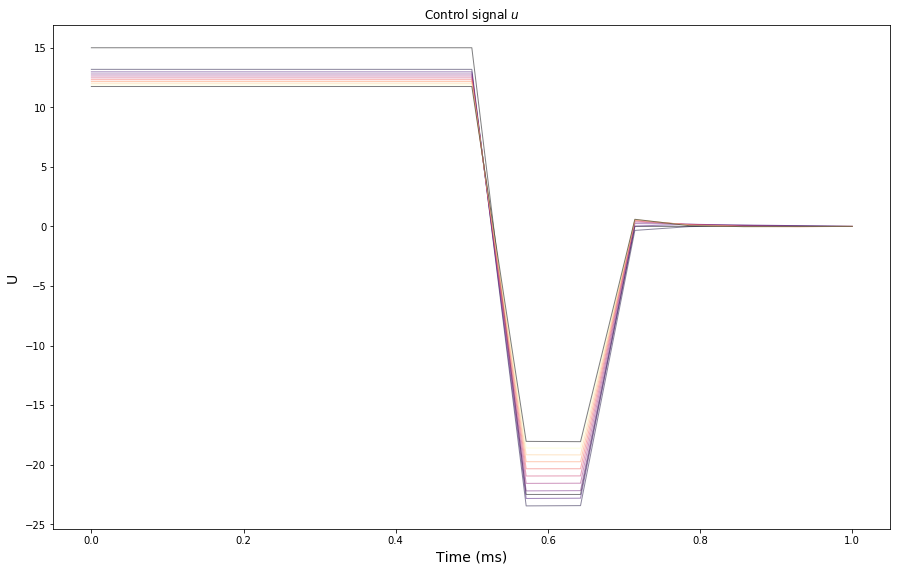

In [18]:
fig_width = 15
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/1.618))
N_show = 10
from cycler import cycler
ax.set_prop_cycle(cycler('color', [plt.cm.magma(h) for h in np.linspace(0, 1, N_show)]))

ax.plot(time, a[::(niter//N_show), :].T, '-', alpha=.5, lw=1)
ax.set_title(r'Control signal $u$')
ax.set_xlabel('Time (ms)', fontsize=14)
ax.set_ylabel('U ', fontsize=14)
#ax.set_xlim(0, 150)


We can also draw the evolution of the position during the movement.

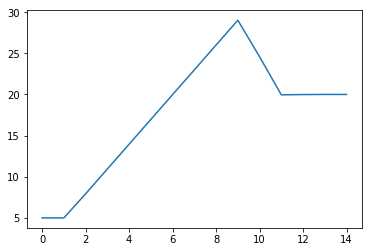

In [19]:
position = np.zeros(T+R);

for i in np.arange(T+R):
    position[i] = (expectation(A, B, x0, u, i))[0];
    
plt.plot(position)
plt.show()

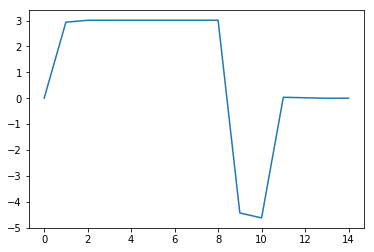

In [20]:
speed = np.zeros(T+R);

for i in np.arange(T+R-1):
    speed[i] = (expectation(A, B, x0, u, i+1))[0]-(expectation(A, B, x0, u, i))[0];
    
plt.plot(speed)
plt.show()

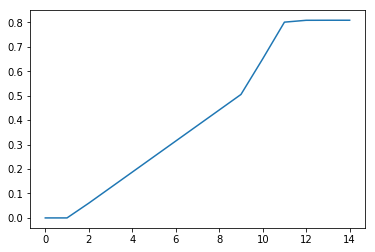

In [21]:
varia = np.zeros(T+R);

for i in np.arange(T+R):
    varia[i] = variance(A, B, k, u, i);
    
plt.plot(varia)
plt.show()

Finally, we trace the position at time T for each iteration.

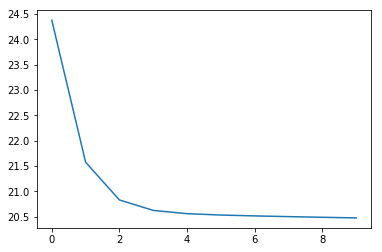

In [22]:
positionT = np.zeros(10);

for i in np.arange(10):
    positionT[i] = (expectation(A, B, x0, a[i], T+1))[0];
    
plt.plot(positionT)
plt.show()